# (MBTI) Myers-Briggs Personality Type Prediction


* Extroversion vs. Introversion
    * I - 0
    * E - 1 
    
* Sensing vs. Intuition 
    * N - 0 
    * S - 1
    
* Thinking vs. Feeling
    * F - 0
    * T - 1
    
* Judging vs. Perceiving
    * P - 0
    * J - 1 

In [1]:
# importing dependencies here
import numpy as np
import pandas as pd
import os

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# feature engineering
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download("wordnet")
nltk.download("vader_lexicon")

# sentiment scoring
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# scikit
# vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# scaling to handle negative values (for Naive Bayes)
from sklearn.preprocessing import MinMaxScaler

# data stratifying and splitting
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

# algorithms/models
# from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# model performance evaluation and selection
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    roc_auc_score,
)

# performance check
import time
import warnings

warnings.filterwarnings("ignore")

# sparse to dense
from sklearn.base import TransformerMixin


class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


# code formatter
%load_ext nb_black

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katjansen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/katjansen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/katjansen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/katjansen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/katjansen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<IPython.core.display.Javascript object>

In [2]:
img_path = os.path.join("..","static","images")

<IPython.core.display.Javascript object>

### Visualizations

In [3]:
# reading the dataset from step 3
personality_data = pd.read_csv("data_ekta/clean_data_3.csv")

<IPython.core.display.Javascript object>

#### Word Clouds

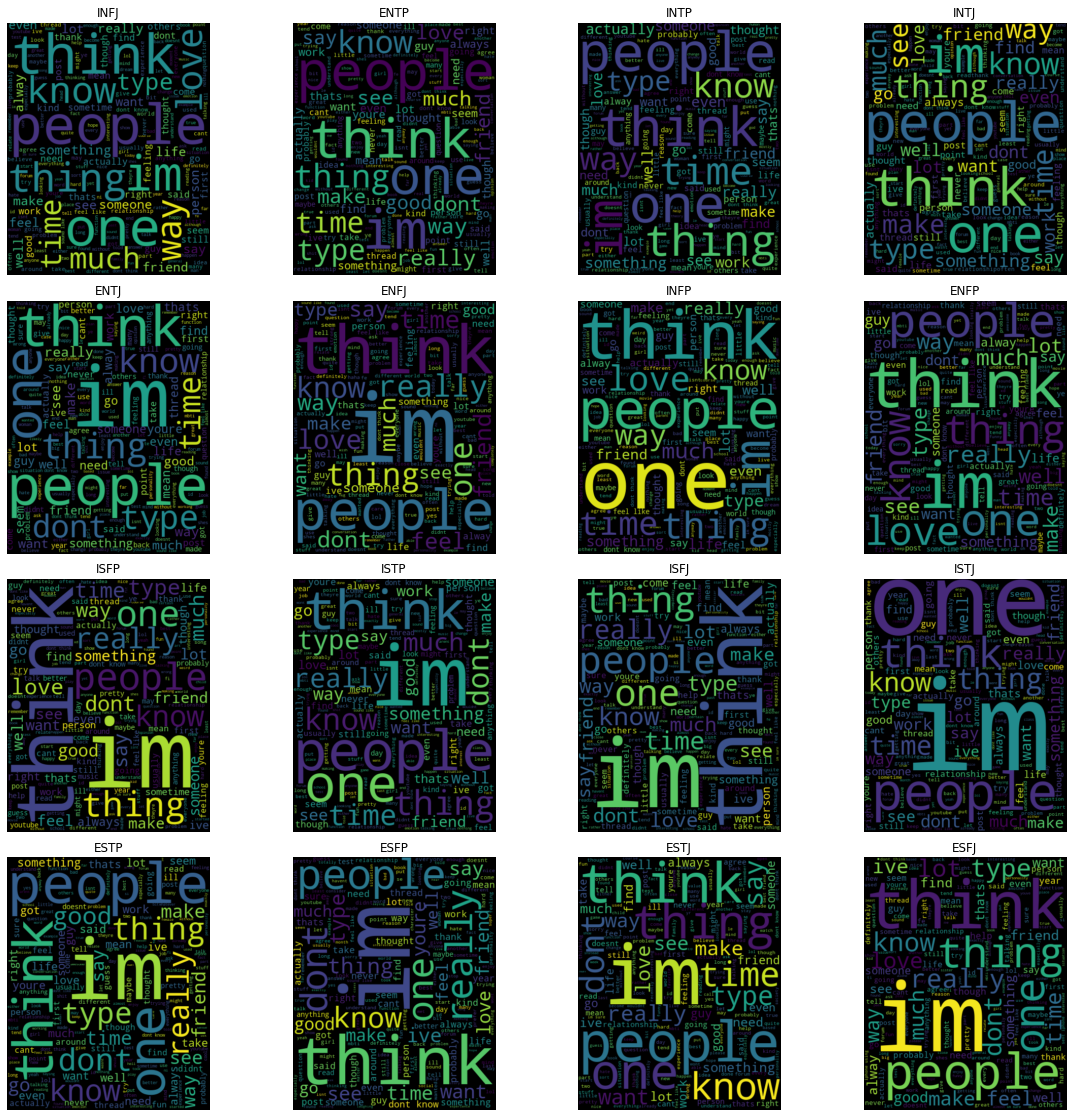

<IPython.core.display.Javascript object>

In [4]:
from wordcloud import WordCloud

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = ax.ravel()

for i, mbti_type in enumerate(personality_data["type"].unique()):
    wordcloud_words = " ".join(
        personality_data[personality_data["type"] == mbti_type]["clean_posts"]
    )
    wordcloud = WordCloud(height=500).generate(wordcloud_words)
    ax[i].imshow(wordcloud, interpolation="bilinear")
    ax[i].axis("off")
    ax[i].set_title(mbti_type)

#### Word Count by Type

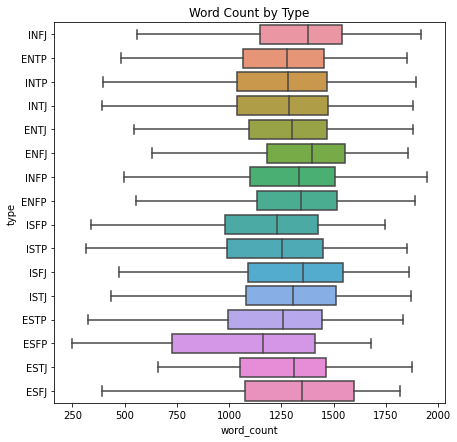

<IPython.core.display.Javascript object>

In [5]:
# boxplot of word counts
plt.figure(figsize=(7, 7))
plt.title("Word Count by Type")
sns.boxplot(y="type", x="word_count", data=personality_data, showfliers=False)
plt.savefig(os.path.join(img_path,"box_wordcount.png"))

#### Compound Sentiment Score by Type

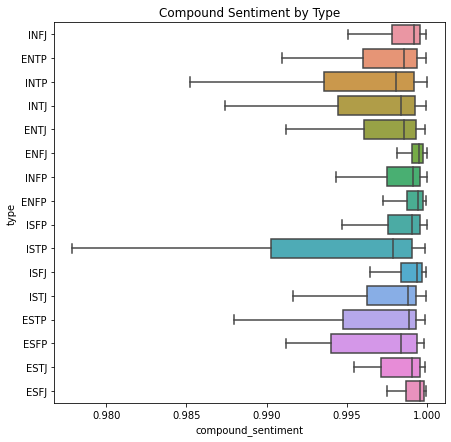

<IPython.core.display.Javascript object>

In [6]:
plt.figure(figsize=(7, 7))
plt.title("Compound Sentiment by Type")
sns.boxplot(y="type", x="compound_sentiment", data=personality_data, showfliers=False)
plt.savefig(os.path.join(img_path,"box_compsent.png"))

#### Positive Sentiment Score by Type

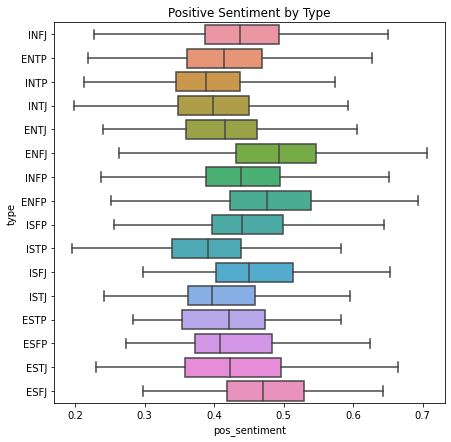

<IPython.core.display.Javascript object>

In [7]:
plt.figure(figsize=(7, 7))
plt.title("Positive Sentiment by Type")
sns.boxplot(y="type", x="pos_sentiment", data=personality_data, showfliers=False)
plt.savefig(os.path.join(img_path,"box_possent.png"))

#### Negative Sentiment Score by Type

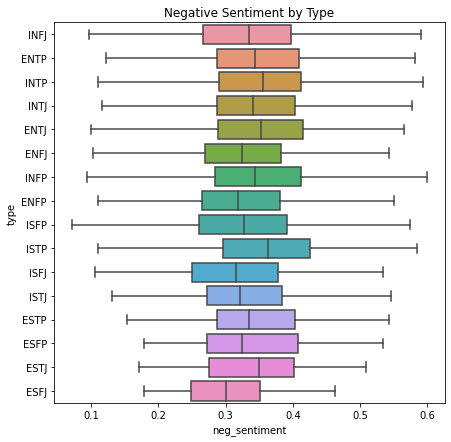

<IPython.core.display.Javascript object>

In [8]:
plt.figure(figsize=(7, 7))
plt.title("Negative Sentiment by Type")
sns.boxplot(y="type", x="neg_sentiment", data=personality_data, showfliers=False)
plt.savefig(os.path.join(img_path,"box_negsent.png"))

#### Neutral Sentiment Score by Type

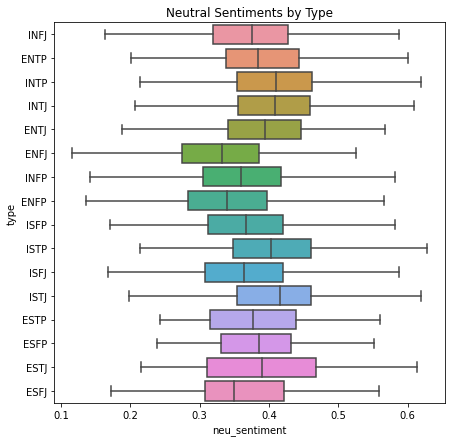

<IPython.core.display.Javascript object>

In [9]:
plt.figure(figsize=(7, 7))
plt.title("Neutral Sentiments by Type")
sns.boxplot(y="type", x="neu_sentiment", data=personality_data, showfliers=False)
plt.savefig(os.path.join(img_path,"box_neusent.png"))

#### Question Marks by Type

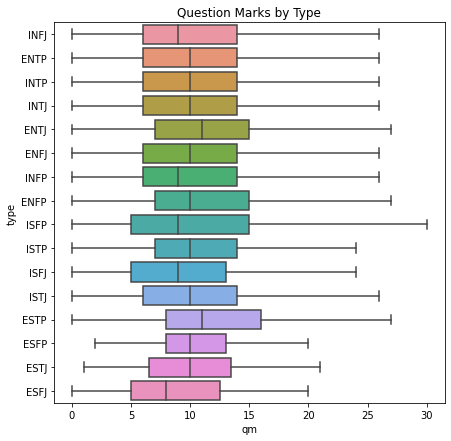

<IPython.core.display.Javascript object>

In [10]:
plt.figure(figsize=(7, 7))
plt.title("Question Marks by Type")
sns.boxplot(y="type", x="qm", data=personality_data, showfliers=False)
plt.savefig(os.path.join(img_path,"box_qm.png"))

#### Exclamation by Type

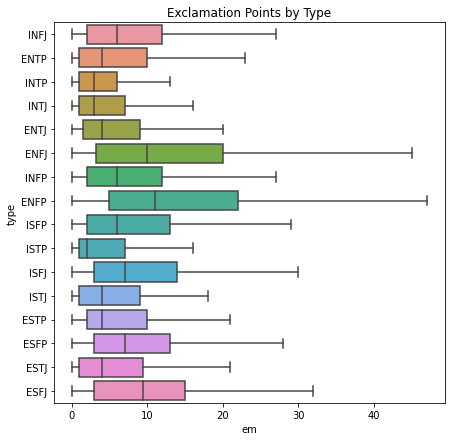

<IPython.core.display.Javascript object>

In [11]:
plt.figure(figsize=(7, 7))
plt.title("Exclamation Points by Type")
sns.boxplot(y="type", x="em", data=personality_data, showfliers=False)
plt.savefig(os.path.join(img_path,"box_em.png"))

#### Colons by Type

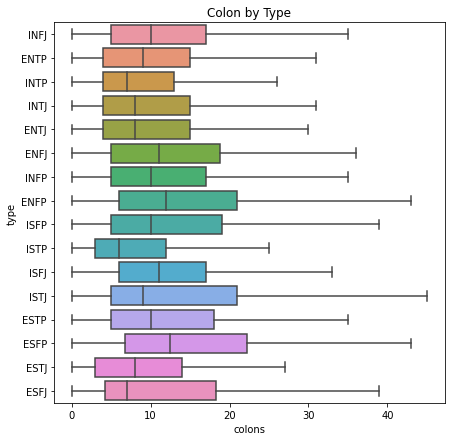

<IPython.core.display.Javascript object>

In [12]:
plt.figure(figsize=(7, 7))
plt.title("Colon by Type")
sns.boxplot(y="type", x="colons", data=personality_data, showfliers=False)
plt.savefig(os.path.join(img_path,"colon.png"))

#### Emojis by Type

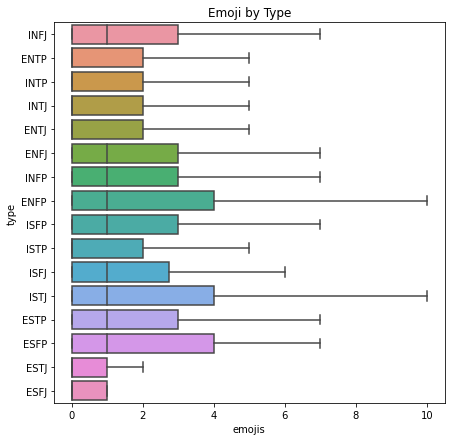

<IPython.core.display.Javascript object>

In [13]:
plt.figure(figsize=(7, 7))
plt.title("Emoji by Type")
sns.boxplot(y="type", x="emojis", data=personality_data, showfliers=False)
plt.savefig(os.path.join(img_path,"box_emoji.png"))

## Scatter Plots

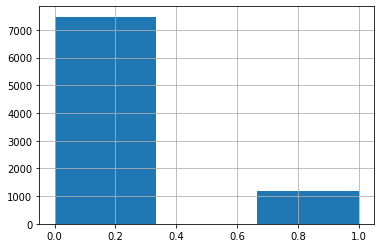

<IPython.core.display.Javascript object>

In [35]:
personality_data['is_Sensing'].hist(bins=3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x146e98750>]],
      dtype=object)

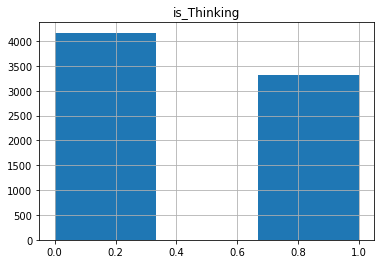

<IPython.core.display.Javascript object>

In [38]:
personality_data[personality_data['is_Sensing']==0][['is_Thinking']].hist(bins=3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x146e9b050>]],
      dtype=object)

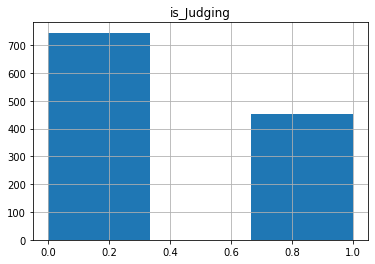

<IPython.core.display.Javascript object>

In [40]:
personality_data[personality_data['is_Sensing']==1][['is_Judging']].hist(bins=3)

In [27]:
personality_data.columns.tolist()

['type',
 'is_Extrovert',
 'is_Sensing',
 'is_Thinking',
 'is_Judging',
 'posts',
 'clean_posts',
 'compound_sentiment',
 'pos_sentiment',
 'neg_sentiment',
 'neu_sentiment',
 'tag_posts',
 'tagged_words',
 'POS_WP$_mean',
 'POS_WP$_std',
 'POS_NNS_mean',
 'POS_NNS_std',
 'POS_UH_mean',
 'POS_UH_std',
 'POS_LS_mean',
 'POS_LS_std',
 'POS_FW_mean',
 'POS_FW_std',
 'POS_NNPS_mean',
 'POS_NNPS_std',
 'POS_JJ_mean',
 'POS_JJ_std',
 'POS_RBR_mean',
 'POS_RBR_std',
 'POS_#_mean',
 'POS_#_std',
 'POS_WRB_mean',
 'POS_WRB_std',
 'POS_NN_mean',
 'POS_NN_std',
 'POS_SYM_mean',
 'POS_SYM_std',
 'POS_VBN_mean',
 'POS_VBN_std',
 'POS_,_mean',
 'POS_,_std',
 'POS_POS_mean',
 'POS_POS_std',
 'POS_VBP_mean',
 'POS_VBP_std',
 'POS_NNP_mean',
 'POS_NNP_std',
 'POS_:_mean',
 'POS_:_std',
 'POS_VBD_mean',
 'POS_VBD_std',
 "POS_''_mean",
 "POS_''_std",
 'POS_``_mean',
 'POS_``_std',
 'POS_MD_mean',
 'POS_MD_std',
 'POS_VB_mean',
 'POS_VB_std',
 'POS_)_mean',
 'POS_)_std',
 'POS_RP_mean',
 'POS_RP_std',
 'P

<IPython.core.display.Javascript object>

In [28]:
len(personality_data.columns.tolist())

141

<IPython.core.display.Javascript object>

In [55]:
for e in personality_data['type'].unique():
    if e.find("SFP")>0 or e.find("STP")>0:
        print(e)

ISFP
ISTP
ESTP
ESFP


<IPython.core.display.Javascript object>